<a href="https://www.kaggle.com/code/ekanemgodwin/my-dinosaur-names?scriptVersionId=194714188" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Name Generation with Keras RNNs: Learn to Generate Realistic Dinosaur and City Names

This notebook was inspired by the programming assignment *Dinosaur Island-Character-Level Language Modeling* in the course ["Sequence Models" on Coursera](https://www.coursera.org/learn/nlp-sequence-models).

In [230]:
# import frequently used libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

Check for available input files with examples to show to the network during training. Multiple datasets are linked to this notebook as input and all of them will be used to train different models later:

In [231]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dinosaur-island/dinos.txt
/kaggle/input/us-cities/uscities.csv
/kaggle/input/us-cities/uscities.xlsx
/kaggle/input/us-cities/license.txt


# Dinosaur Name Dataset

## Preparing the dataset

Import the dinosaur name dataset and investigate the data it contains. There are about 1500 dino names, sorted alphabetically. Note that the names all have different length.

In [232]:
dino_corpus = pd.read_csv("/kaggle/input/dinosaur-island/dinos.txt", header=None, names=['name'])
dino_corpus = dino_corpus.drop_duplicates()

dino_corpus

,name
0,Aachenosaurus
1,Aardonyx
2,Abdallahsaurus
3,Abelisaurus
4,Abrictosaurus
...,...
1531,Zunityrannus
1532,Zuolong
1533,Zuoyunlong
1534,Zupaysaurus


In [233]:
from collections import namedtuple
Vocabulary = namedtuple('Vocabulary', ['VOCAB_SIZE', 'END_TOKEN', 'character2index', 'index2character', 'c_to_i', 'i_to_c'])

def get_vocabulary(data_column):
    all_characters = set()
    for entry in data_column:
        all_characters |= set(entry.lower()) #shorthand in Python for performing an in-place union of sets.
    
    all_characters = sorted(all_characters)
    
    print(f"The vocabulary includes {len(all_characters)} characters: {all_characters}")
    
    char2idx = {}
    idx2char = {}
    
    for idx, char in enumerate(all_characters):
        char2idx[char] = idx+1
        idx2char[idx+1] = char

    end_token = 0 
    
    char2idx['END'] = end_token
    idx2char[end_token] = 'END'
    
    vocab_size = len(all_characters) + 1
    
    # turn into function so it's callable
    char2idx_fcn = lambda c: char2idx[c]
    idx2char_fcn = lambda i: idx2char[i]
    
    return Vocabulary(vocab_size, end_token, char2idx_fcn, idx2char_fcn, char2idx, idx2char)

dino_vocab = get_vocabulary(dino_corpus['name'])

The vocabulary includes 26 characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Define some helper functions to convert between words, indices and one-hot representation

In [234]:
def onehot2indices(hotmax):
    return tf.math.argmax(hotmax, axis=-1).numpy().flatten()

def word2indices(word, vocab):
    return [vocab.character2index(c.lower()) for c in word]

def indices2word(indices, vocab):
    return ''.join([vocab.index2character(i) for i in indices])

In [235]:
TrainingData = namedtuple('TrainingData', ['inputs', 'targets'])

def convert_to_training_data(raw_data, vocab):
    # Convert the strings to arrays of indices
    indices = raw_data.map(lambda w: word2indices(w.strip(), vocab))
    
    # Prepend inputs with invalid index (-1), will result in all-zero one-hot encoding
    inputs = indices.map(lambda l: [-1] + l)
    # Append outputs with END_TOKEN to signal end of the word
    outputs = indices.map(lambda l: l + [vocab.END_TOKEN])
    
    input_arrays = list(inputs)
    output_arrays = list(outputs)

    # Determine maximum sequence length
    max_length = max(max(len(seq) for seq in input_arrays), max(len(seq) for seq in output_arrays))
    
    # Pad sequences to ensure uniform length
    X_train = pad_sequences(input_arrays, maxlen=max_length, padding='post', value=vocab.VOCAB_SIZE)
    y_train = pad_sequences(output_arrays, maxlen=max_length, padding='post', value=vocab.VOCAB_SIZE)
    
    # Convert to one-hot encoding
    X_train = tf.one_hot(X_train, depth=vocab.VOCAB_SIZE)
    y_train = tf.one_hot(y_train, depth=vocab.VOCAB_SIZE)
    
    return TrainingData(X_train, y_train)

dino_training_data = convert_to_training_data(dino_corpus['name'], dino_vocab)

# RNN Model Architecture

Standard parameters

In [236]:
NameGenerationModel = namedtuple('NameGenerationModel', ['training_model', 'sampling_cell'])

BATCH_SIZE = 64
NUM_EPOCHS = 100

# Choice of optimizer - Adam and RMSprop both seem to work well
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, verbose=1, patience=10, cooldown=30)

cosine_similarity = tf.keras.metrics.CosineSimilarity(axis=1)

# Uncomment this for better debugging of the custom metric
# tf.config.run_functions_eagerly(True)

@tf.function
def character_acc(y_true, y_pred, axis=1):
    num_characters = tf.cast(tf.size(y_true) / tf.shape(y_true)[axis], tf.float32)
    idx_true = tf.math.argmax(y_true, axis=axis)
    idx_pred = tf.math.argmax(y_pred, axis=axis)
    matching_count = tf.cast(tf.math.count_nonzero(idx_true == idx_pred), tf.float32)
    score = matching_count / num_characters
    return score

def plot_history(history):
    for key, values in history.items():
        plt.plot(values)
        plt.title(key)
        plt.xlabel('epoch')
        plt.show()

For generating new names after training
- `generate_name1` samples next character from the probability distribution
- `generate_name2` incorporates temperature scaling

In [237]:
def generate_name1(model, char_to_idx, idx_to_char, max_length=20):
    # Initialize the sequence with zeros
    input_seq = np.zeros((1, 1, len(char_to_idx)))

    # List to store generated characters
    generated_name = []

    for _ in range(max_length):
        # Predict the next character
        predictions = model.predict(input_seq, verbose=0)
        predictions = predictions[0, -1, :]
        next_idx = np.random.choice(range(len(predictions)), p = predictions)

        # Convert the predicted index to a character
        next_char = idx_to_char[next_idx]
        if next_char == 'END':
            break
            
        generated_name.append(next_char)

        # Update the input sequence with the new character
        new_input_seq = np.zeros((1, 1, len(char_to_idx)))
        new_input_seq[0, 0, next_idx] = 1
        input_seq = np.concatenate([input_seq, new_input_seq], axis=1)

    # Convert list of characters to a string
    return ''.join(generated_name)

def sample(predictions, temperature=1.0):
    """
    Sample from the probability distribution.
    """
    predictions = np.asarray(predictions).astype('float64')
    #take log of probabilities (add 1e-7 to prevent log of 0), then use temperature scaling
    #lower temp means more confident predictions, higher temp is more random
    predictions = np.log(predictions + 1e-7) / temperature 
    exp_preds = np.exp(predictions)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(predictions), p=preds)

def generate_name2(model, char_to_idx, idx_to_char, max_length=20, temperature=1.0):
    # Initialize the sequence with zeros
    input_seq = np.zeros((1, 1, len(char_to_idx)))

    # List to store generated characters
    generated_name = []

    for _ in range(max_length):
        # Predict the next character
        predictions = model.predict(input_seq, verbose=0)[0, -1, :]
        
        # Sample from the predictions
        next_idx = sample(predictions, temperature)

        # Convert the predicted index to a character
        next_char = idx_to_char[next_idx]
        # Stop if the end token is predicted
        if next_char == 'END':
            break
            
        generated_name.append(next_char)

        # Update the input sequence with the new character
        new_input_seq = np.zeros((1, 1, len(char_to_idx)))
        new_input_seq[0, 0, next_idx] = 1
        input_seq = np.concatenate([input_seq, new_input_seq], axis=1)

    # Convert list of characters to a string
    return ''.join(generated_name)

## My model

In [238]:
def get_model2(memory_size, vocab_size):
    model = tf.keras.Sequential([
        tf.keras.Input((None, vocab_size)),  # Input layer for sequences of one-hot encoded vectors
        tf.keras.layers.Masking(mask_value=0), #ignore padding values
        tf.keras.layers.SimpleRNN(memory_size, return_sequences=True, activation='tanh'),  # SimpleRNN layer
        tf.keras.layers.Dense(vocab_size, activation='softmax')  # Dense layer to output probabilities
    ])
    model.summary()
    
    return NameGenerationModel(model, None)  # `None` for sampling_cell since it's not needed

# Define the memory size and vocabulary size
MEMORY_SIZE = 50
dino_model2 = get_model2(MEMORY_SIZE, dino_vocab.VOCAB_SIZE)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_7 (Masking)          (None, None, 27)          0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, None, 50)          3900      
_________________________________________________________________
dense_7 (Dense)              (None, None, 27)          1377      
Total params: 5,277
Trainable params: 5,277
Non-trainable params: 0
_________________________________________________________________


In [239]:
dino_model2.training_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[character_acc, cosine_similarity])

dino_history2 = dino_model2.training_model.fit(x=dino_training_data.inputs, y=dino_training_data.targets, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, callbacks=[lr_callback])

Epoch 1/100
24/24 [==============================] - 3s 31ms/step - loss: 1.0703 - character_acc: 0.3933 - cosine_similarity: 0.1024
Epoch 2/100
24/24 [==============================] - 1s 32ms/step - loss: 0.8421 - character_acc: 0.4751 - cosine_similarity: 0.1410
Epoch 3/100
24/24 [==============================] - 1s 33ms/step - loss: 0.7807 - character_acc: 0.4819 - cosine_similarity: 0.1541
Epoch 4/100
24/24 [==============================] - 1s 30ms/step - loss: 0.7491 - character_acc: 0.4758 - cosine_similarity: 0.1615
Epoch 5/100
24/24 [==============================] - 1s 31ms/step - loss: 0.7302 - character_acc: 0.4700 - cosine_similarity: 0.1652
Epoch 6/100
24/24 [==============================] - 1s 29ms/step - loss: 0.7175 - character_acc: 0.4745 - cosine_similarity: 0.1679
Epoch 7/100
24/24 [==============================] - 1s 30ms/step - loss: 0.7072 - character_acc: 0.4663 - cosine_similarity: 0.1712
Epoch 8/100
24/24 [==============================] - 1s 31ms/step - l

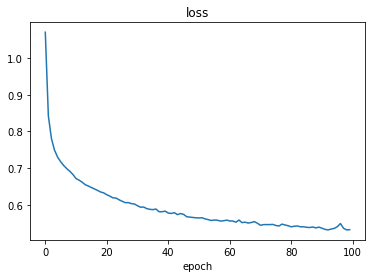

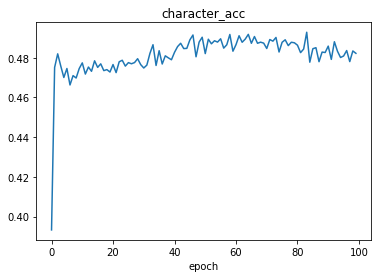

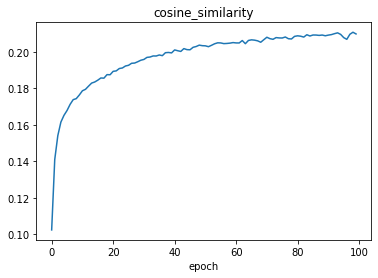

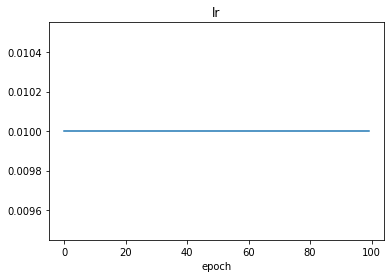

In [240]:
plot_history(dino_history2.history)

In [241]:
# Example usage:
generated_name = generate_name1(dino_model2.training_model, dino_vocab.c_to_i, dino_vocab.i_to_c)
print("Generated Dinosaur Name:", generated_name)

Generated Dinosaur Name: drotytonosaurus


In [242]:
# Example usage with default temperature:
generated_name = generate_name2(dino_model2.training_model, dino_vocab.c_to_i, dino_vocab.i_to_c)
print("Generated Dinosaur Name with Temperature 1.0:", generated_name)

# Example usage with temperature adjustment:
generated_name = generate_name2(dino_model2.training_model, dino_vocab.c_to_i, dino_vocab.i_to_c, temperature=0.7)
print("Generated Dinosaur Name with Temperature 0.7:", generated_name)

Generated Dinosaur Name with Temperature 1.0: korngosaurus
Generated Dinosaur Name with Temperature 0.7: testadosaurus


In [244]:
dino_model2.training_model.save('dino_model.keras')

In [248]:
loaded_model = tf.keras.models.load_model(
    "/kaggle/working/dino_model.keras",
    custom_objects={'character_acc': character_acc}
)

generated_name = generate_name2(loaded_model, dino_vocab.c_to_i, dino_vocab.i_to_c, temperature=0.7)
print("Generated Dinosaur Name:", generated_name)

Generated Dinosaur Name: rithaarisaurus
